# Graph Dataset Loading and Batching
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [4]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

from simgnn.datasets import VertexDynamics, CellData

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


**Add TENSION(edge) and PRESSURE(cell) attr**

- Edge tensions
$$T_{edge:(i,j)} = \Lambda_{ij}(t)+\sum_{k\in\{cells\ for\ (i,j)\}}K_p^{(k)}(p^{(k)}-p_0^{(k)})$$
- Cell pressures
$$\pi_{cell:k} = -2K_a^{(k)}(a^{(k)}-a_0^{(k)})$$

**Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

## Working with PyTorch Geometric

- **Node features** : velocities from previous frames (~ 5 frames--> Alvaro Sanchez-Gonzalez, *et al.* 2020 \[ASG2020\])
- **Edge features** : can use edge directions (optional, might help to speed up training)
- **Current position** : technically a node feature, and needs to be normalized but not processed by the network.
- Positions (Cartesian) to polar edge attributes: `transforms.Polar` \[[link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.Polar)\], I can also implement or use the `transforms.Cartesian` which computes direction vectors (position pairs -to- normalized direction vectors).
- need transform for velocity noise (use src from example transforms above and ASG2020 paper)
- Train-g movie: max edge length ~ 3.25 a.u.

- `simgnn.datasets.VertexDynamics` (child of `torch_geometric.data.Dataset`)

In [6]:
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/')
vtxdata

VertexDynamics(95)

In [8]:
data=vtxdata[0]

In [9]:
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 678], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [83]:
loader = DataLoader([vtxdata[0], vtxdata[25]], batch_size=2)
batch = next(iter(loader))
print(batch)
# nx.draw(to_networkx(batch, to_undirected=True),pos=dict(enumerate(batch.pos.numpy())), node_size=60)

Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], edge_index=[2, 1356], edge_tensions=[678], node2cell_index=[2, 1200], pos=[480, 2], x=[480, 5, 2], y=[480, 2])


In [10]:
# data = vtxdata[0]
# print(data)
# plt.figure(figsize=[10,10])
# plt.title('Monolayer Graph with Cell-to-Nodes Edges')
# nx.draw(to_networkx(data), pos=dict(enumerate(data.pos.numpy())), node_size=30)
# for ci in range(data.num_cells):
#     c_vxpos = data.pos[data.node2cell_index[0][data.node2cell_index[1]==ci]]
#     cpos = c_vxpos.mean(dim=0)
#     for vi in c_vxpos:
#         plt.plot([vi[0],cpos[0]],[vi[1],cpos[1]],lw=3,alpha=.5)
#     plt.plot(cpos[0],cpos[1],'bo',ms=10,alpha=.5)
# # plt.savefig('cell2node.png',dpi=100)

In [85]:
# cell_pos = np.stack([d1.pos[d1.cell2node_index[1,d1.cell2node_index[0]==c]].mean(dim=0).numpy() for c in range(d1.num_cells)])
# plt.figure(figsize=[20,20])
# nx.draw(to_networkx(d1),pos=dict(enumerate(d1.pos.numpy())), node_size=60)
# plt.plot(cell_pos[:,0],cell_pos[:,1],'ro',ms=10, alpha=.5)
# for c, c_pos in enumerate(cell_pos):
#     plt.text(c_pos[0],c_pos[1], f'{d1.cell_pressures[c]:.3f}') 

In [21]:
# t=5
# Dt = 1
# # plt.figure(figsize=[25,25])
# nx.draw(to_networkx(vtxdata[t], to_undirected=True),pos=dict(enumerate(vtxdata[t].pos.numpy())), node_size=60)
# nx.draw(to_networkx(vtxdata[t+Dt], to_undirected=True),pos=dict(enumerate(vtxdata[t+Dt].pos.numpy())),
#         node_size=20,width=4,
#         node_color='#FF00FF',edge_color='#51C5FF',alpha=.5)
# plt.quiver(vtxdata[t].pos.numpy()[:,0], vtxdata[t].pos.numpy()[:,1],
#            vtxdata[t].y.numpy()[:,0],vtxdata[t].y.numpy()[:,1],
#            units='xy',angles='xy',scale=.25,color='r')

In [24]:
# Compare computed and original *edge lengths*
# dist_fn = T.Distance(norm=False)
# compute cartesian distances
# dist_fn(data);

## Data Normalisation

In [7]:
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/')
vtxdata

VertexDynamics(95)

In [59]:
data = vtxdata[0]
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [34]:
v_vel = torch.cat([d.y for d in vtxdata],0)
e_vec = torch.cat([(d.pos[d.edge_index[1]]-d.pos[d.edge_index[0]]) for d in vtxdata],0)

v_spd = v_vel.pow(2).sum(dim=1).sqrt()
e_len = e_vec.pow(2).sum(dim=1).sqrt()

print(f'> Node speed\n\trange: [{v_spd.min():4.3g} {v_spd.max():4.3g}]; s.d.: {v_spd.std():4.3g} ||'+
      f' median: {v_spd.median():4.3g}; mean: {v_spd.mean():4.3g};')
print(f'> Node velocity\n\trange: [{v_vel.min():4.3g} {v_vel.max():4.3g}]; s.d.: {v_vel.std():4.3g} ||'+
      f' median: {v_vel.median():4.3g}; mean: {v_vel.mean():4.3g};')

print(f'> Edge len\n\trange: [{e_len.min():4.3g} {e_len.max():4.3g}]; s.d.: {e_len.std():4.3g} ||'+
      f' median: {e_len.median():4.3g}; mean: {e_len.mean():4.3g};')
print(f'> Edge vect-s\n\trange: [{e_vec.min():4.3g} {e_vec.max():4.3g}]; s.d.: {e_vec.std():4.3g} ||'+
      f' median: {e_vec.median():4.3g}; mean: {e_vec.mean():4.3g};')

> Node speed
	range: [1.35e-05 0.147]; s.d.: 0.019 || median: 0.024; mean: 0.0281;
> Node velocity
	range: [-0.134 0.139]; s.d.: 0.024 || median: 0.000116; mean: 6.56e-09;
> Edge len
	range: [2.86e-06 3.27]; s.d.:  0.5 || median: 0.875; mean: 0.857;
> Edge vect-s
	range: [-3.25 2.62]; s.d.: 0.702 || median: -0.000488; mean: -0.0101;


**Length unit** = average edge length (over whole dataset)
- divide all "edge lengths", node "speeds" and "velocities" by mean edge length $l_0$, this measures all len-s in $l_0$ units. 

**Normalisation** <br>
Normalising lengths, velocities (and areas) requires speacial considerations, since relative edge lengths and node vel-s are inputs to the GNN model and need to be same for the *simulated* and the *real* datasets.
- `[ data.edge_attr ]` *edge directions* $e_i$, and *edge lens* $l_i$: since lengths are in range `[0, l_max]`, scale by 20 average lengths and no mean shift to zero. We get
$$l^{norm}_i = \frac{l_i}{20\cdot{}l_0}$$
this scales lengths to values comparable to node velocity magnitudes which are about 1/20's of length or 5% of $l_0$ (do the same for $e^{norm}_i$).
- `[ data.x, data.y ]` *node velocities* $\Delta{}v_i$: scale by one average edge length, $$\Delta{}v_i^{norm} = \frac{\Delta{}v_i}{l_0}$$
this applies to both *node attributes and targets*.

- `l_0 = 0.857 (average edge length, simulated data)`

> Edge vectors (norm)
	range: [-0.19 0.153]; s.d.: 0.0409 || median: -2.85e-05; mean: -0.000588;
> Node velocity (norm)
	range: [-0.157 0.162]; s.d.: 0.028 || median: 0.000136; mean: 7.69e-09;


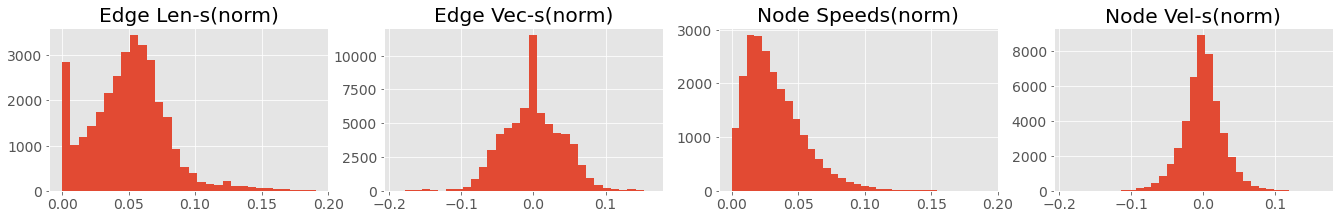

In [55]:
e_len_norm = e_len/(20*0.857)
e_vec_norm = e_vec/(20*0.857)

v_spd_norm = v_spd/(0.857)
v_vel_norm = v_vel/(0.857)
print(f'> Edge vectors (norm)\n\trange: [{e_vec_norm.min():4.3g} {e_vec_norm.max():4.3g}]; s.d.: {e_vec_norm.std():4.3g} ||'+
      f' median: {e_vec_norm.median():4.3g}; mean: {e_vec_norm.mean():4.3g};')
print(f'> Node velocity (norm)\n\trange: [{v_vel_norm.min():4.3g} {v_vel_norm.max():4.3g}]; s.d.: {v_vel_norm.std():4.3g} ||'+
      f' median: {v_vel_norm.median():4.3g}; mean: {v_vel_norm.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(e_len_norm.numpy(),bins=30); ax1.set_title('Edge Len-s(norm)')
ax2 = plt.subplot(1,4,2)
ax2.hist(e_vec_norm.view(-1,).numpy(),bins=30); ax2.set_title('Edge Vec-s(norm)')

ax3 = plt.subplot(1,4,3,sharex=ax1)
ax3.hist(v_spd_norm.numpy(),bins=30); ax3.set_title('Node Speeds(norm)')
ax4 = plt.subplot(1,4,4, sharex=ax2)
ax4.hist(v_vel_norm.view(-1,).numpy(),bins=30); ax4.set_title('Node Vel-s(norm)');

> Cell Pressures
	range: [-0.069 2.41]; s.d.:  0.4 || median: 1.05; mean: 1.06;
> Edge Tensions
	range: [0.0167 3.83]; s.d.: 0.53 || median: 1.32; mean: 1.42;


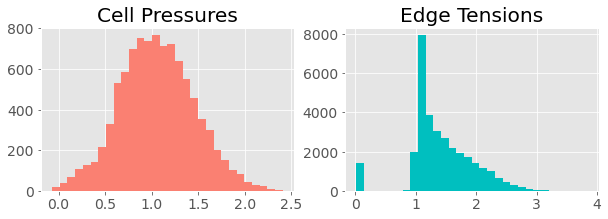

In [57]:
c_pres = torch.cat([d.cell_pressures for d in vtxdata],0)
e_tens = torch.cat([d.edge_tensions for d in vtxdata],0)

print(f'> Cell Pressures\n\trange: [{c_pres.min():4.3g} {c_pres.max():4.3g}]; s.d.: {c_pres.std():4.3g} ||'+
      f' median: {c_pres.median():4.3g}; mean: {c_pres.mean():4.3g};')
print(f'> Edge Tensions\n\trange: [{e_tens.min():4.3g} {e_tens.max():4.3g}]; s.d.: {e_tens.std():4.3g} ||'+
      f' median: {e_tens.median():4.3g}; mean: {e_tens.mean():4.3g};')

plt.figure(figsize=[10,3])
ax1 = plt.subplot(1,2,1)
ax1.hist(c_pres.view(-1,).numpy(),bins=30,color='salmon');
ax1.set_title('Cell Pressures')

ax2 = plt.subplot(1,2,2)
ax2.hist(e_tens.view(-1,).numpy(),bins=30,color='c');
ax2.set_title('Edge Tensions');